In [87]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Install Required Library

In [88]:
!pip install category_encoders

In [89]:
!pip install catboost

# Import

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from category_encoders import TargetEncoder
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [161]:
train = pd.read_csv('/gdrive/MyDrive/02_Citizens_grievances_Hackathon/dataset/train.csv')
test = pd.read_csv('/gdrive/MyDrive/02_Citizens_grievances_Hackathon/dataset/test.csv')

In [92]:
# for col in train.columns:
#   print(col, '-----nunique------', train[col].nunique(), '----nulls----', train[col].isnull().sum(), '-------', train[col].dtypes)

# EDA

In [162]:
date_cols = []
for col in train.columns:
  if col.endswith('date'):
    date_cols.append(col)

train[date_cols] = train[date_cols].astype('datetime64[ns]')

train['date_diff_1'] =  (train['decisiondate'].dt.year - train['introductiondate'].dt.year) * 12 + train['decisiondate'].dt.month - train['introductiondate'].dt.month

## test

test[date_cols] = test[date_cols].astype('datetime64[ns]')

test['date_diff_1'] =  (test['decisiondate'].dt.year - test['introductiondate'].dt.year) * 12 + test['decisiondate'].dt.month - test['introductiondate'].dt.month

In [163]:
train['judge_year'] = train['judgementdate'].dt.year
# train['judge_month'] = train['judgementdate'].dt.month
# train['judge_day'] = train['judgementdate'].dt.day
# train['judge_day_of_week'] = train['judgementdate'].dt.dayofweek
# train['judge_week_of_year'] = train['judgementdate'].dt.weekofyear

train['judge_year_diff'] = max(train['judge_year'])-train['judge_year']


test['judge_year'] = test['judgementdate'].dt.year
# test['judge_month'] = test['judgementdate'].dt.month
# test['judge_day'] = test['judgementdate'].dt.day
# test['judge_day_of_week'] = test['judgementdate'].dt.dayofweek
# test['judge_week_of_year'] = test['judgementdate'].dt.weekofyear

test['judge_year_diff'] = max(test['judge_year'])-test['judge_year']


train.drop(['judge_year'], axis = 1, inplace=True)
test.drop(['judge_year'], axis = 1, inplace=True)

# submission 8  (add respondent.0)

In [164]:
te = TargetEncoder().fit(train['respondent.0'], train['importance'])
train['respondent.0'] = te.transform(train['respondent.0'])
test['respondent.0'] = te.transform(test['respondent.0'])

# Submission 12 parties.1

In [165]:
te = TargetEncoder().fit(train['parties.1'], train['importance'])
train['parties.1'] = te.transform(train['parties.1'])
test['parties.1'] = te.transform(test['parties.1'])

In [166]:
appno_id = test['appno']

In [167]:
pd.options.display.max_rows = None

In [168]:
train.shape

(8878, 330)

### Removed columns

['ecli', 'itemid', 'sharepointid']   

['application',
 'languageisocode',
 'originatingbody_type',
 'documentcollectionid=CASELAW',
 'documentcollectionid=JUDGMENTS',
 'documentcollectionid=ENG',
 'applicability=51',
 'applicability=7',
 'applicability=28',
 'applicability=29',
 'applicability=31',
 'applicability=19',
 'applicability=40',
 'applicability=34',
 'applicability=27',
 'applicability=64',
 'applicability=4',
 'applicability=77',
 'paragraphs=7-2',
 'paragraphs=28-3',
 'paragraphs=27-1-b',
 'paragraphs=32-2',
 'paragraphs=46-4']   

 ['issue.24',
 'issue.25',
 'issue.26',
 'parties.2',
 'respondent.2',
 'respondent.3',
 'respondent.4']

'country.name'   

decisiondate -----nunique------ 232 ----nulls---- 8202   
introductiondate -----nunique------ 511 ----nulls---- 8202   
docname -----nunique------ 8682 ----nulls---- 0   

originatingbody_name **same as** originatingbody

respondentOrderEng  **same as** respondent.0

'judgementdate' **same as** 'kpdate'


'doctypebranch' **same as** 'documentcollectionid=CHAMBER','documentcollectionid=COMMITTEE','documentcollectionid=GRANDCHAMBER'   

['parties.0', 'parties.1', 'parties.2'] **same as** originatingbody  

separateopinion -> True False

In [169]:
train.drop(['ecli', 'itemid', 'sharepointid'], axis = 1, inplace= True)

preparties = ['parties.0', 'parties.2']
train.drop(preparties, axis= 1, inplace=True)

del1 = []
for col in train.columns:
  if (train[col].nunique() == 1 and train[col].isnull().sum() == 0):
    del1.append(col)
train.drop(del1, axis= 1, inplace=True)

del2 = []
for col in train.columns:
  if (train[col].nunique() == 1):
    del2.append(col)
train.drop(del2, axis= 1, inplace=True)

train.drop(['documentcollectionid=CHAMBER','documentcollectionid=COMMITTEE','documentcollectionid=GRANDCHAMBER'], axis= 1, inplace=True)
train.drop('country.name', axis= 1, inplace=True)
train.drop(['decisiondate', 'introductiondate'], axis= 1, inplace=True)
train.drop(['docname', 'originatingbody_name', 'respondentOrderEng', 'kpdate'], axis= 1, inplace=True)
train.drop('appno', axis= 1, inplace=True)

In [170]:
test.drop(['ecli', 'itemid', 'sharepointid'], axis = 1, inplace= True)
test.drop(preparties, axis= 1, inplace=True)
test.drop(del1, axis= 1, inplace=True)
test.drop(del2, axis= 1, inplace=True)
test.drop(['documentcollectionid=CHAMBER','documentcollectionid=COMMITTEE','documentcollectionid=GRANDCHAMBER'], axis= 1, inplace=True)
test.drop('country.name', axis= 1, inplace=True)
test.drop(['decisiondate', 'introductiondate'], axis= 1, inplace=True)
test.drop(['docname', 'originatingbody_name', 'respondentOrderEng', 'kpdate'], axis= 1, inplace=True)
test.drop('appno', axis= 1, inplace=True)

In [171]:
print(train.shape)
print(test.shape)

(8878, 285)
(4760, 284)


## more columns to remove

In [172]:
article_cols=[]
for col in train.columns:
  if col.startswith('article'):
    article_cols.append(col)


applicability_cols=[]
for col in train.columns:
  if col.startswith('applicability'):
    applicability_cols.append(col)


paragraphs_cols=[]
for col in train.columns:
  if col.startswith('paragraphs='):
    paragraphs_cols.append(col)

ccl_article_cols=[]
for col in train.columns:
  if col.startswith('ccl_article='):
    ccl_article_cols.append(col)

ohe_cols = []
ohe_cols.extend(article_cols)
ohe_cols.extend(applicability_cols)
ohe_cols.extend(paragraphs_cols)

In [173]:
# train['sum_article']=0
# for col in article_cols:
#   train['sum_article'] += train[col]

# train['sum_paragraphs']=0
# for col in paragraphs_cols:
#   train['sum_paragraphs'] += train[col]


In [174]:
# test['sum_article']=0
# for col in article_cols:
#   test['sum_article'] += test[col]

# test['sum_paragraphs']=0
# for col in paragraphs_cols:
#   test['sum_paragraphs'] += test[col]


In [175]:
remove_col =[]
for col in ohe_cols:
  if (train[col].value_counts()[0]<15) or (train[col].value_counts()[1]<15):
    remove_col.append(col)
    # print(col)

# remove_col

In [176]:
len(remove_col)

111

In [177]:
train.drop(remove_col, axis=1, inplace=True)
test.drop(remove_col, axis=1, inplace=True)

## Encoding Techniques

   
**OHE** = doctypebranch, originatingbody, separateopinion, typedescription, article={number}, applicability={number}, ccl_article={Type}, paragraphs={number}

**Hashing Encoder** = issue, country



In [178]:
issue_cols=[]
for col in train.columns:
  if col.startswith('issue.'):
    issue_cols.append(col)

train[issue_cols] = train[issue_cols].notnull().astype('int')
train[issue_cols] = train[issue_cols].fillna(0)

test[issue_cols] = test[issue_cols].notnull().astype('int')
test[issue_cols] = test[issue_cols].fillna(0)

train['issue_sum']=0
for col in issue_cols:
  train['issue_sum'] += train[col]

test['issue_sum']=0
for col in issue_cols:
  test['issue_sum'] += test[col]

In [179]:
X = train.drop('importance', axis= 1)
y = train.importance

In [180]:
train.shape

(8878, 175)

### OHE

In [181]:
ohe_cols=[]

In [182]:
article_cols=[]
for col in train.columns:
  if col.startswith('article'):
    article_cols.append(col)

applicability_cols=[]
for col in train.columns:
  if col.startswith('applicability'):
    applicability_cols.append(col)

paragraphs_cols=[]
for col in train.columns:
  if col.startswith('paragraphs='):
    paragraphs_cols.append(col)

ccl_article_cols=[]
for col in train.columns:
  if col.startswith('ccl_article='):
    ccl_article_cols.append(col)

In [183]:
ohe_cols = ['doctypebranch', 'originatingbody', 'separateopinion', 'typedescription']
ohe_cols.extend(article_cols)
ohe_cols.extend(applicability_cols)
ohe_cols.extend(paragraphs_cols)
ohe_cols.extend(ccl_article_cols)

len(ohe_cols)

141

In [184]:
ohe = OneHotEncoder(drop= 'first').fit(X[ohe_cols])
train_ohe = pd.DataFrame(ohe.transform(X[ohe_cols]).todense(), 
                                columns=ohe.get_feature_names())

In [185]:
test_ohe = pd.DataFrame(ohe.transform(test[ohe_cols]).todense(), columns=ohe.get_feature_names())

In [186]:
print(train_ohe.shape)
print(test_ohe.shape)

(8878, 176)
(4760, 176)


In [187]:
issue_cols=[]
for col in train.columns:
  if col.startswith('issue.'):
    issue_cols.append(col)

In [188]:
hash_enco = ce.HashingEncoder(cols=issue_cols, drop_invariant = True, ).fit(X,y)
train_hash = hash_enco.transform(X)

In [189]:
train_hash[['c2','c3']] = train_hash[['col_2', 'col_3']]

In [190]:
train_hash.drop(['col_2', 'col_3'], axis=1, inplace=True)

In [191]:
hash_enco_2 = ce.HashingEncoder(cols=['country.alpha2'], drop_invariant = True).fit(train_hash,y)
train_hashed = hash_enco_2.transform(train_hash)

In [192]:
## TEST

test_hash = hash_enco.transform(test)

test_hash[['c2','c3']] = test_hash[['col_2', 'col_3']]
test_hash.drop(['col_2', 'col_3'], axis=1, inplace=True)

test_hashed = hash_enco_2.transform(test_hash)

In [193]:
print(train_hashed.shape)
print(test_hashed.shape)

(8878, 159)
(4760, 159)


In [194]:
train_hashed.drop(ohe_cols, axis=1, inplace=True)

In [195]:
test_hashed.drop(ohe_cols, axis=1, inplace=True)

In [196]:
train = pd.concat([train_hashed, train_ohe], axis=1)

In [197]:
test = pd.concat([test_hashed, test_ohe], axis=1)

In [198]:
print(train.shape)
print(test.shape)

(8878, 194)
(4760, 194)


In [199]:
train.drop(['judgementdate', 'respondent.1'], axis=1, inplace=True)
test.drop(['judgementdate', 'respondent.1'], axis=1, inplace=True)

In [200]:
train['date_diff_1'] = train['date_diff_1'].fillna(0)
test['date_diff_1'] = test['date_diff_1'].fillna(0)

In [201]:
train.shape

(8878, 192)

In [202]:
y.shape

(8878,)

In [203]:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.20,random_state=123)

In [204]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(7102, 192)
(1776, 192)
(7102,)
(1776,)


## Model Building

### Randomized Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

rfc_1 = RandomForestClassifier(n_jobs=-1)

In [ ]:
## set Hyper Parameter Distributions

# Check max_features>0% & max_features<=100%
max_features = np.round(np.random.normal(loc=0.25, scale=0.1, size=15),2)
max_features[max_features <= 0.01] = 0.01
max_features[max_features > 1.0] = 1.0

model_params = {
    # randomly sample numbers from 4 to 100 estimators
    'n_estimators': np.random.uniform(10,100, 10).astype(int),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': list(max_features),
    # uniform distribution from 0.01 to 0.2
    'min_samples_split': np.round(np.random.uniform(0.01, 0.2, 10),2),
    # randomly sample numbers from 4 to 15
    'max_depth': np.random.uniform(2,20, 10).astype(int)
}

In [ ]:
clf_hp = RandomizedSearchCV(estimator=rfc_1, param_distributions=model_params, n_iter=500, cv=5, scoring='accuracy', n_jobs=-1)
clf_hp.fit(new_train_1, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
clf_hp.best_params_

{'max_depth': 19,
 'max_features': 0.25,
 'min_samples_split': 0.02,
 'n_estimators': 94}

In [ ]:
# rf_pred_hp = clf_hp.predict(new_test)

## Random Forest Classifier

In [213]:
# clf = RandomForestClassifier(n_estimators=400, max_depth=19, min_samples_leaf=2, random_state=123)
clf = RandomForestClassifier(random_state=123, max_depth=15, max_features=0.2, min_samples_split=0.01, n_estimators=34)
clf.fit(X=new_train_1, y=y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=19, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.02,
                       min_weight_fraction_leaf=0.0, n_estimators=94,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [209]:
clf.feature_importances_

array([2.90821154e-04, 7.64562958e-05, 7.90604366e-04, 2.86312443e-04,
       6.09354058e-04, 2.57039684e-04, 9.50818278e-05, 2.24950259e-05,
       2.54168597e-02, 8.92021992e-02, 2.02260023e-02, 8.75529090e-03,
       7.49338917e-02, 1.37232314e-01, 1.28629219e-01, 1.13925334e-01,
       1.03612043e-02, 2.80384346e-02, 1.65306143e-04, 4.52252351e-05,
       1.85257092e-04, 2.93314249e-02, 5.72964172e-03, 2.47540160e-03,
       4.78300380e-04, 7.14194961e-05, 2.89838923e-05, 1.30661753e-05,
       1.18318628e-04, 2.01568791e-04, 1.09571195e-02, 1.76418950e-03,
       1.32983232e-03, 2.32792954e-05, 0.00000000e+00, 7.60849594e-04,
       5.41271156e-03, 5.58070055e-05, 3.14610367e-05, 2.63311663e-04,
       2.90127349e-04, 1.47572032e-04, 5.27055281e-04, 1.92149273e-04,
       6.75912694e-02, 1.49493444e-04, 3.66434080e-02, 3.13864086e-04,
       1.62943031e-02, 1.54962479e-03, 1.05178042e-04, 1.14954276e-04,
       3.76636471e-05, 3.51728134e-04, 1.51766748e-04, 1.69444301e-04,
      

In [210]:
importances = clf.feature_importances_
indices = np.argsort(importances)
print(indices)

[ 58  34 186 163 143 164 124 125 159  68  99 130 134 178  79 129 132  98
 167  27  57 133 135  59   7 168  33 123 118  26  38 155 109 114 138 152
  52  61 158  77 139  19 191 105 146 156  56 157  37 182  75 128  25 174
   1 179 189 106 172 127 107 173   6 101  78 120  50 111 119 122 175 110
  51 151  28  66 112  69  62  60 184 169 137  70 149  41  45  54  91 131
 170  85 171 190  18  94 148 100 150  55 121 145  20 154  43 188  82  29
 115 142 141  83 103  80 136 140 144  63 176   5  71  39 117 183   3 104
 166  40   0 153 108  47  76  96 116 147  53 160  87 181  65 187  89 185
  24 126 113  88  42  72   4 162 180  35   2 161  67  81  84 102 165 177
  32  49  31  23  93  73  86  64  36  22  74  11  16  30  95  97  48  10
   8  17  21  92  46  44  90  12   9  15  14  13]


In [211]:
selected_indices = indices[importances[indices]>0.0005] #0.00001 --88.9 ---- no hp
selected_cols = [X_train.columns[i] for i in selected_indices]
new_train = X_train[selected_cols]
new_val = X_val[selected_cols]

new_train_1 = train[selected_cols]
new_test = test[selected_cols]

In [212]:
new_train_1.shape

(8878, 45)

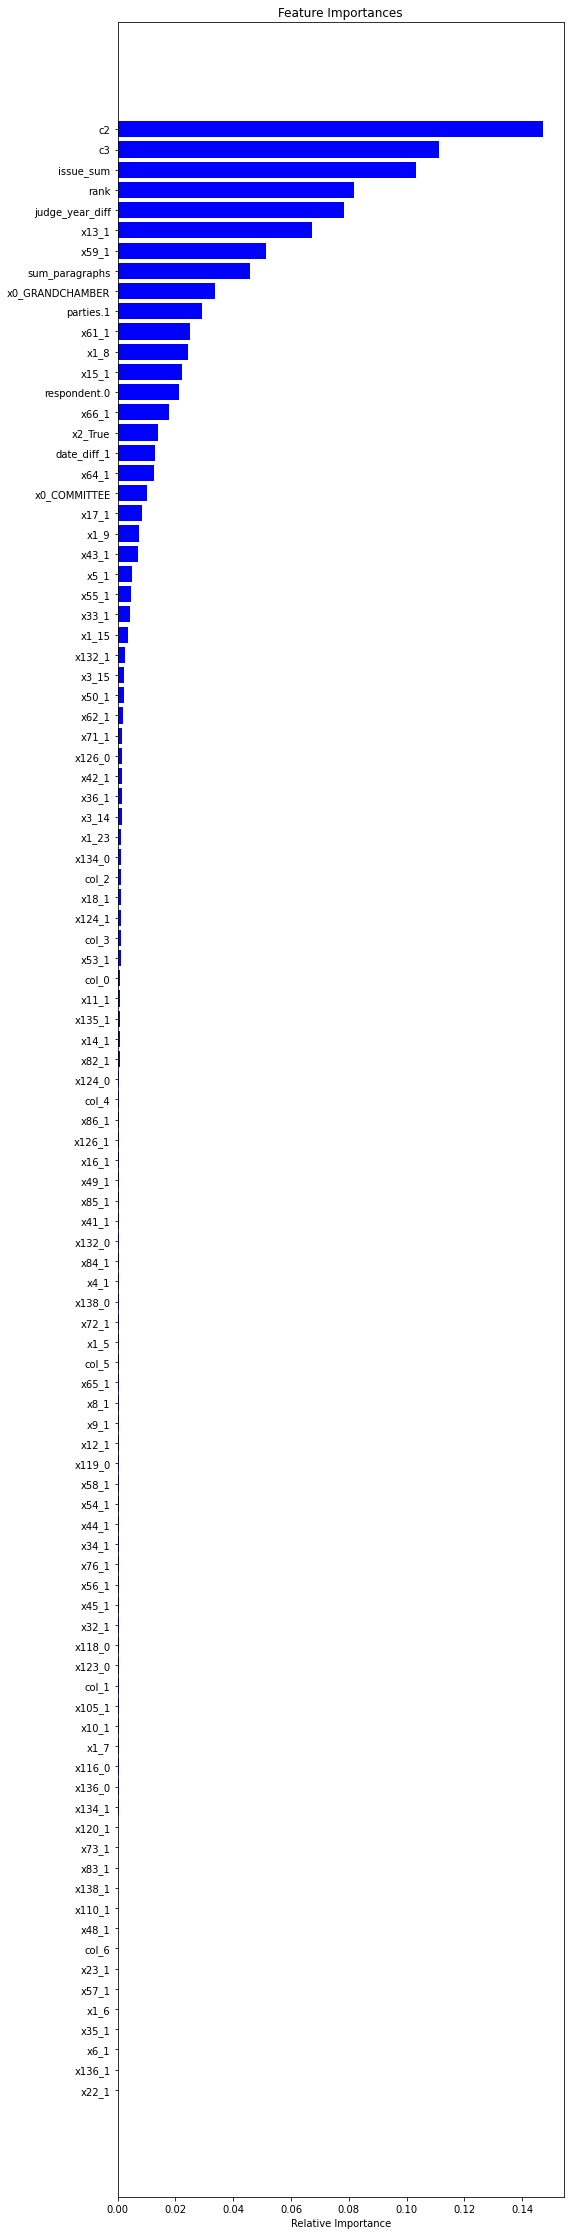

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
features = new_train_1.columns

plt.rcParams["figure.figsize"] = (8,40)

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# y_pred = clf.predict(new_train)
# print("Accuracy for Train set:")
# print(accuracy_score(y_train,y_pred))

# y_pred_val = clf.predict(new_val)
# print("Accuracy for Test set:")
# print(accuracy_score(y_val,y_pred_val))


In [64]:
# new_pred = clf.predict(new_test)

## Light GBM GridSearchCV

In [76]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [77]:
# Model in use
LGBM = LGBMClassifier() 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [150,200,300,500],
           "max_depth" : [5,10],
           "learning_rate" : [0.1, 0.2, 0.3, 0.4]}
 
CV_LGBM = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5)

In [78]:
%time CV_LGBM.fit(X=new_train_1, y=y)

CPU times: user 12min 16s, sys: 20.5 s, total: 12min 37s
Wall time: 6min 24s


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_

In [79]:
# Find best model
best_lgbm_model = CV_LGBM.best_estimator_
print (CV_LGBM.best_score_, CV_LGBM.best_params_)

0.8947604527365755 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}


## Light GBM Classifier

In [214]:
lgb = LGBMClassifier(random_state=123, reg_lambda=0.3)
lgb.fit(new_train_1, y)
# lgb_pred = lgb.predict(X_val)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = lgb.predict(new_train)
print("Accuracy for Train set:")
print(accuracy_score(y_train,y_pred))

y_pred_val = lgb.predict(X_val)
print("Accuracy for Test set:")
print(accuracy_score(y_val,y_pred_val))


Accuracy for Train set:
0.9667699239650802
Accuracy for Test set:
0.8913288288288288


In [ ]:
lgb_pred_1 = lgb.predict(new_test)

## GBM GridSearchCV

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
# Model in use
GBM = GradientBoostingClassifier() 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [150,200,300],
           "max_depth" : [5,10],
           "learning_rate" : [0.1, 0.2, 0.3, 0.4]}
 
CV_GBM = GridSearchCV(estimator=GBM, param_grid=param_grid, cv=5)

In [74]:
%time CV_GBM.fit(X=new_train_1, y=y)

CPU times: user 42min 47s, sys: 547 ms, total: 42min 48s
Wall time: 42min 56s


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [75]:
# Find best model
best_gbm_model = CV_GBM.best_estimator_
print (CV_GBM.best_score_, CV_GBM.best_params_)

0.8990786345547572 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}


In [ ]:
# y_pred = best_gbm_model.predict(new_train)
# print("Accuracy for Train set:")
# print(accuracy_score(y_train,y_pred))

# y_pred_val = best_gbm_model.predict(new_val)
# print("Accuracy for Test set:")
# print(accuracy_score(y_val,y_pred_val))


## GradientBoostingClassifier

In [215]:
GBM_model = GradientBoostingClassifier(n_estimators=500,
                                       learning_rate=0.2,
                                       subsample=0.8, random_state=123)

GBM_model.fit(new_train_1, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = GBM_model.predict(new_train)
print("Accuracy for Train set:")
print(accuracy_score(y_train,y_pred))

y_pred_val = GBM_model.predict(new_val)
print("Accuracy for Test set:")
print(accuracy_score(y_val,y_pred_val))


Accuracy for Train set:
0.9970430864545199
Accuracy for Test set:
0.8980855855855856


In [ ]:
gbm_pred = GBM_model.predict(new_test)

## XG Boost Hyperparameter Tuning

In [82]:
from xgboost import XGBClassifier

In [83]:
XGB = XGBClassifier(n_jobs=-1)
 
# Use a grid over parameters of interest
param_grid = {
     'colsample_bytree': np.linspace(0.6, 0.8, 3),
     'n_estimators':[100,200,150,300],
     'max_depth': [5, 10]
}

CV_XGB = GridSearchCV(estimator=XGB, param_grid=param_grid, cv= 5)

In [85]:
%time CV_XGB.fit(X = new_train_1, y=y)

CPU times: user 47min 23s, sys: 7.89 s, total: 47min 30s
Wall time: 24min 5s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': array([0.6, 0.7, 0.8]),
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 150, 300

In [86]:
# Find best model
best_xgb_model = CV_XGB.best_estimator_
print (CV_XGB.best_score_, CV_XGB.best_params_)

0.9002150627939429 {'colsample_bytree': 0.6, 'max_depth': 10, 'n_estimators': 100}


In [ ]:
# y_pred = best_xgb_model.predict(new_train)
# print("Accuracy for Train set:")
# print(accuracy_score(y_train,y_pred))

# y_pred_val = best_xgb_model.predict(new_val)
# print("Accuracy for Test set:")
# print(accuracy_score(y_val,y_pred_val))


Accuracy for Train set:
0.9985919459307238
Accuracy for Test set:
0.8952702702702703


## XG Boost Classifier

In [216]:
XGB_model = XGBClassifier(random_state=123, colsample_bytree= 0.6, max_depth= 10, n_estimators= 200)
%time XGB_model.fit(X=new_train_1, y=y)

CPU times: user 9.72 s, sys: 25.9 ms, total: 9.74 s
Wall time: 9.79 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = XGB_model.predict(new_train)
print("Accuracy for Train set:")
print(accuracy_score(y_train,y_pred))

y_pred_val = XGB_model.predict(new_val)
print("Accuracy for Test set:")
print(accuracy_score(y_val,y_pred_val))


Accuracy for Train set:
0.9022810475922275
Accuracy for Test set:
0.8834459459459459


In [ ]:
XGB_y_pred = XGB_model.predict(new_test)

## Voting Regressor

In [217]:
import numpy as np
from sklearn.ensemble import VotingClassifier

In [218]:
vr = VotingClassifier([('LightGBM', lgb),("gbm1",GBM_model),("Random Forest1",clf),('xgboost', XGB_model)], )

In [219]:
vr.fit(new_train_1,y)

VotingClassifier(estimators=[('LightGBM',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=10,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=300, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=123, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             su...
                                            colsample_byno

In [220]:
vr_pred = vr.predict(new_test)

# Submission

In [221]:
submission_file = pd.DataFrame([appno_id, vr_pred]).T

In [222]:
submission_file.columns = ['appno', 'importance']

In [223]:
# submission_file['importance'] = submission_file['importance'].astype('int64')

In [224]:
submission_file.to_csv("Submission_151.csv",index=False)